# Wildfire Smoke Controls on Gross Primary Production in Central Canada

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.stats import pearsonr

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

# get Sam's stepwise selection function
import statsmodels.api as sm
%run ../lab02/Tutorial_2_2021_functions2.ipynb

# show full dataframes
pd.set_option('max_columns', None)

In [2]:
# get data
data_in = pd.read_csv("drf_timeseries.csv", parse_dates=True, index_col=0)

In [3]:
# select just the growing/wildfire season (may-sept, inclusive)
#data_in["datetime"] = pd.to_datetime(data_in["datetime"])
growing_season = pd.DataFrame()
for month in [5,6,7,8,9]:
    growing_season = growing_season.append(data_in[pd.to_datetime(data_in['datetime']).dt.month == month])
growing_season = growing_season.sort_values(by='datetime')

## Find which measurements have the most complete data

In [14]:
# check data for completeness
def check_complete(data_in):
    """
    Prints out the percentage of non-NaN values in a dataset
    """
    data_len = np.shape(data_in)[0]
    for key in data_in.keys():
        if key != "datetime":
            not_nans = np.shape((data_in[np.isnan(data_in[key]) == False]))[0]
            completeness = not_nans / data_len * 100
            print(f"{key}:  {round(completeness,2)} %")
    return None
 

def keep_complete(data_in, thres):
    """
    returns a dataframe that contains a percentage of non-NaNs above
    a specified threshhold
    """
    data_out = pd.DataFrame()
    data_out["datetime"] = data_in["datetime"]
    data_len = np.shape(data_in)[0]
    for key in data_in.keys():
        if key != "datetime":
            not_nans = np.shape((data_in[np.isnan(data_in[key]) == False]))[0]
            completeness = not_nans / data_len * 100
            if completeness >= thres:
                data_out[key] = data_in[key]
    return data_out

In [5]:
check_complete(growing_season)

smoke:  98.84 %
AOD_1640nm:  5.23 %
AOD_1020nm:  6.23 %
AOD_870nm:  6.45 %
AOD_865nm:  0.0 %
AOD_779nm:  0.0 %
AOD_675nm:  6.44 %
AOD_667nm:  0.0 %
AOD_620nm:  0.0 %
AOD_560nm:  0.0 %
AOD_555nm:  0.0 %
AOD_551nm:  0.0 %
AOD_532nm:  0.0 %
AOD_531nm:  0.0 %
AOD_510nm:  0.0 %
AOD_500nm:  5.51 %
AOD_490nm:  0.0 %
AOD_443nm:  0.0 %
AOD_440nm:  6.32 %
AOD_412nm:  0.0 %
AOD_400nm:  0.0 %
AOD_380nm:  6.43 %
AOD_340nm:  6.38 %
Precipitable_Water(cm):  6.44 %
AOD_681nm:  0.0 %
AOD_709nm:  0.0 %
Ozone(Dobson):  6.45 %
NO2(Dobson):  6.45 %
USTAR:  35.13 %
TA:  36.0 %
WD:  36.01 %
WS:  36.02 %
NEE_PI:  26.2 %
FC:  34.41 %
SC:  34.61 %
H:  34.89 %
SH:  0.0 %
LE:  34.41 %
SLE:  0.0 %
G:  0.0 %
TS_1:  36.02 %
TS_2:  36.02 %
P:  36.63 %
RH:  35.81 %
PA:  36.6 %
CO2_1:  34.64 %
CO2_2:  27.2 %
VPD_PI:  35.81 %
SWC_1:  9.05 %
SWC_2:  9.05 %
NETRAD:  35.51 %
PPFD_IN:  36.57 %
SW_IN:  35.65 %
SW_DIF:  0.0 %
PPFD_OUT:  34.95 %
SW_OUT:  35.49 %
LW_IN:  36.0 %
LW_OUT:  35.93 %
H2O:  34.64 %
RECO_PI:  4.32 %
AP

Pretty dismal. We need the AOD data, so set a cutoff at 5%. We can hopefully interpolate the rest

In [6]:
comp_data = keep_complete(growing_season, 5.0)
check_complete(comp_data) # see if that worked

smoke:  98.84 %
AOD_1640nm:  5.23 %
AOD_1020nm:  6.23 %
AOD_870nm:  6.45 %
AOD_675nm:  6.44 %
AOD_500nm:  5.51 %
AOD_440nm:  6.32 %
AOD_380nm:  6.43 %
AOD_340nm:  6.38 %
Precipitable_Water(cm):  6.44 %
Ozone(Dobson):  6.45 %
NO2(Dobson):  6.45 %
USTAR:  35.13 %
TA:  36.0 %
WD:  36.01 %
WS:  36.02 %
NEE_PI:  26.2 %
FC:  34.41 %
SC:  34.61 %
H:  34.89 %
LE:  34.41 %
TS_1:  36.02 %
TS_2:  36.02 %
P:  36.63 %
RH:  35.81 %
PA:  36.6 %
CO2_1:  34.64 %
CO2_2:  27.2 %
VPD_PI:  35.81 %
SWC_1:  9.05 %
SWC_2:  9.05 %
NETRAD:  35.51 %
PPFD_IN:  36.57 %
SW_IN:  35.65 %
PPFD_OUT:  34.95 %
SW_OUT:  35.49 %
LW_IN:  36.0 %
LW_OUT:  35.93 %
H2O:  34.64 %
PPFD_DIF:  34.87 %


In [7]:
data=comp_data
# get all the AOD 
aod_list = []
for key in data.keys():
    if "AOD" in key:
        aod_list.append(key)
        print(key)

AOD_1640nm
AOD_1020nm
AOD_870nm
AOD_675nm
AOD_500nm
AOD_440nm
AOD_380nm
AOD_340nm


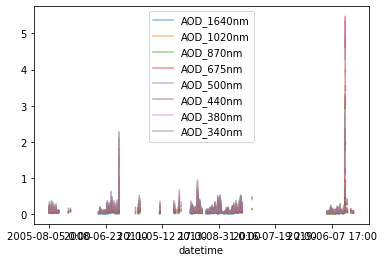

In [8]:
data.plot("datetime", aod_list, alpha=0.5);

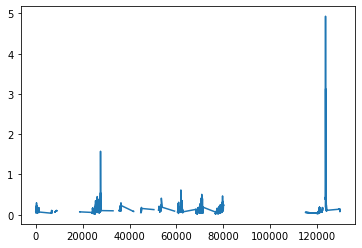

In [9]:
# interpolation method I settled on (subject to change). Try messing around with this, 
# lots of methods available, most arent appropriate
data["AOD_500nm"].interpolate(method='slinear', limit=200, limit_direction='both').plot();

<AxesSubplot:xlabel='datetime'>

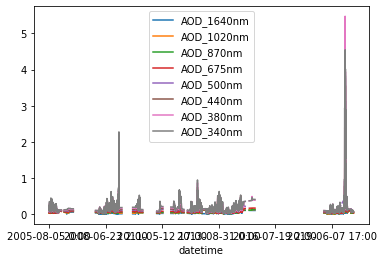

In [10]:
# now apply the interpolation scheme to all AOD sets
for key in aod_list:
    data[key] = data[key].interpolate(method='slinear', limit=500, limit_direction='both')
data.plot('datetime', aod_list)

<AxesSubplot:>

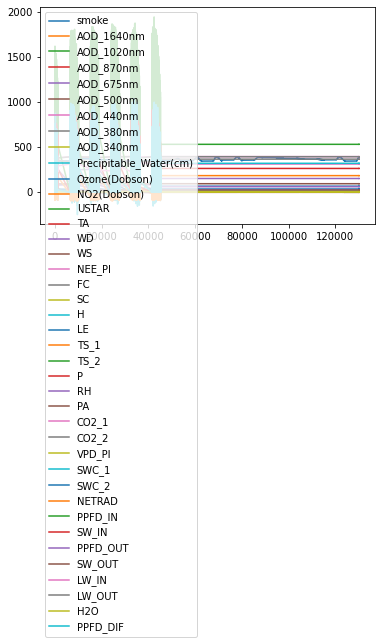

In [11]:
# Blanket interpolate all data using the same scheme (this is a bad idea)
data_interp = data.interpolate(method='linear')#.dropna()
data_interp.plot()

In [15]:
# after we finish messing about with interpolations, drop all rows that still have missing data
data_complete = data_interp.dropna()
data_complete

,datetime,smoke,AOD_1640nm,AOD_1020nm,AOD_870nm,AOD_675nm,AOD_500nm,AOD_440nm,AOD_380nm,AOD_340nm,Precipitable_Water(cm),Ozone(Dobson),NO2(Dobson),USTAR,TA,WD,WS,NEE_PI,FC,SC,H,LE,TS_1,TS_2,P,RH,PA,CO2_1,CO2_2,VPD_PI,SWC_1,SWC_2,NETRAD,PPFD_IN,SW_IN,PPFD_OUT,SW_OUT,LW_IN,LW_OUT,H2O,PPFD_DIF
8242,2006-07-14 10:00,0.0,0.011873,0.023081,0.032157,0.041611,0.068252,0.083878,0.104789,0.118861,0.550710,386.808406,0.145447,0.7720,18.3210,285.900,5.1885,-8.5640,-8.0600,-0.5035,195.050,217.90,11.0200,10.4440,0.0,66.6470,94.0215,377.30,384.648050,0.7035,16.8600,26.8000,589.560,1493.150,739.070,46.325,57.375,334.175,426.315,14.3450,221.130
8243,2006-07-14 11:00,0.0,0.011926,0.023127,0.032205,0.041671,0.068331,0.083956,0.104894,0.119011,0.550844,386.820865,0.145481,0.8675,19.5515,289.010,6.0275,-10.1680,-9.7705,-0.3995,255.850,215.00,12.0940,10.9465,0.0,56.5045,94.0470,375.55,384.640195,0.9900,16.6725,26.7075,659.875,1642.400,815.545,50.990,63.405,341.230,433.495,13.0600,296.280
8244,2006-07-14 12:00,0.0,0.011980,0.023173,0.032253,0.041732,0.068409,0.084033,0.104999,0.119162,0.550978,386.833325,0.145516,0.9635,20.6100,275.120,5.6445,-10.3535,-9.8720,-0.4805,330.900,267.15,12.9515,11.5650,0.0,49.6345,94.0450,374.20,384.632339,1.2240,16.4850,26.6150,713.930,1794.450,881.870,54.275,66.805,340.415,441.550,12.2800,233.085
8245,2006-07-14 13:00,0.0,0.012034,0.023219,0.032300,0.041793,0.068488,0.084111,0.105104,0.119312,0.551113,386.845784,0.145551,0.9225,21.3995,274.725,5.6650,-9.2910,-9.2995,0.0090,315.400,296.20,13.2550,11.9365,0.0,42.9795,94.0475,373.10,384.624484,1.4535,16.2975,26.5225,668.555,1671.140,832.565,50.995,63.150,344.600,445.460,11.2450,258.050
8246,2006-07-14 14:00,0.0,0.012088,0.023266,0.032348,0.041854,0.068567,0.084188,0.105209,0.119462,0.551247,386.858244,0.145586,0.9050,21.9030,276.360,6.2945,-5.4675,-5.5430,0.0760,263.800,217.30,13.2525,12.0495,0.0,36.8225,94.0555,373.50,384.616628,1.6610,16.1100,26.4300,631.355,1625.190,803.415,51.480,62.250,337.635,447.450,10.0625,192.200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130253,2020-06-14 5:00,5.0,0.021229,0.022221,0.025137,0.031780,0.119943,0.052859,0.062735,0.057933,0.336040,387.701968,0.123415,0.2145,9.8395,152.570,1.3130,0.5935,0.0335,0.5605,15.865,67.39,6.6740,6.9555,0.0,61.5730,94.8320,395.20,394.200000,0.4695,21.6200,36.2900,184.395,531.235,263.915,25.790,24.960,312.525,367.085,7.6890,321.070
130254,2020-06-14 6:00,5.0,0.021229,0.022221,0.025137,0.031780,0.119943,0.052859,0.062735,0.057933,0.336040,387.701968,0.123415,0.2145,9.8395,152.570,1.3130,0.5935,0.0335,0.5605,15.865,67.39,6.6740,6.9555,0.0,61.5730,94.8320,395.20,394.200000,0.4695,21.6200,36.2900,184.395,531.235,263.915,25.790,24.960,312.525,367.085,7.6890,321.070
130255,2020-06-14 7:00,5.0,0.021229,0.022221,0.025137,0.031780,0.119943,0.052859,0.062735,0.057933,0.336040,387.701968,0.123415,0.2145,9.8395,152.570,1.3130,0.5935,0.0335,0.5605,15.865,67.39,6.6740,6.9555,0.0,61.5730,94.8320,395.20,394.200000,0.4695,21.6200,36.2900,184.395,531.235,263.915,25.790,24.960,312.525,367.085,7.6890,321.070
130256,2020-06-14 8:00,5.0,0.021229,0.022221,0.025137,0.031780,0.119943,0.052859,0.062735,0.057933,0.336040,387.701968,0.123415,0.2145,9.8395,152.570,1.3130,0.5935,0.0335,0.5605,15.865,67.39,6.6740,6.9555,0.0,61.5730,94.8320,395.20,394.200000,0.4695,21.6200,36.2900,184.395,531.235,263.915,25.790,24.960,312.525,367.085,7.6890,321.070


## Part 2: Try PCA 

In [19]:
#data = data_complete.drop("datetime", axis=1)
data = data_interp.drop("datetime", axis=1).dropna()

n_modes = np.min(np.shape(data))
pca = PCA(n_components = n_modes)
PCs = pca.fit_transform(data)
eigvecs = pca.components_
fracVar = pca.explained_variance_ratio_

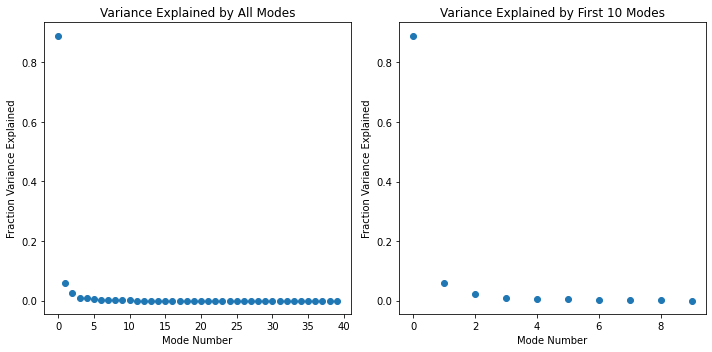

In [20]:
#plot fraction of variance explained by each mode
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(range(len(fracVar)),fracVar)
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('Variance Explained by All Modes')

plt.subplot(1,2,2)
n_modes_show = 10
plt.scatter(range(n_modes_show),fracVar[:n_modes_show])
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('Variance Explained by First ' + str(n_modes_show) + ' Modes')

plt.tight_layout()

plt.show()

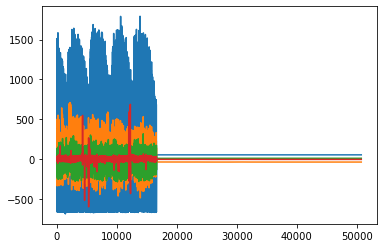

In [21]:
plt.plot(PCs[...,:4]);

This works about as we expect, the vast majority is explained by the first few modes. Now, what are the biggest contributors to these modes?

## Stepwise Linear Regression

Perform stepwise linear regression on the PCs to create a predictive model with inputs

**PCs $\rightarrow$ CO2 Fluxes**

or, if we do rotated PCA:

**smoke, PCs $\rightarrow$ CO2 Fluxes**

In [22]:
# assign predictors and predictands
X = pd.DataFrame(PCs)
Y = data["FC"]

print(X.shape)
print(Y.shape)
# do stepwise regression
#result = stepwise_selection(X, Y)

#print('resulting features:')
#print(result)

(50711, 40)
(50711,)


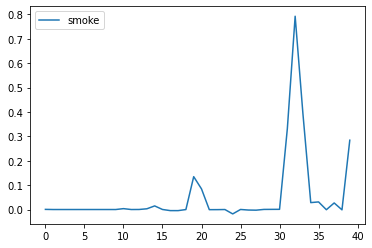

In [23]:
plt.plot(eigvecs[0], label=data.columns[0])
plt.legend()

## To Do

- Interpolate all columns, eyeball-optimizing between coverage and faithful interpolated values
- Figure out how to represent smoke as input and CO2 flux data as output
- Try it again with rotated PCA
- Write up the presentation


- find characteristic patterns after grouping by smoke level?